In [1]:
!pip install pandas numpy
!pip install scikit-learn
!pip install tqdm matplotlib
!pip install nltk gensim

In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
diagnoses = notes = pd.read_csv('/content/drive/MyDrive/AI in HealthCare/MIMIC III Data/DIAGNOSES_ICD.csv.gz', compression='gzip')
admissions = notes = pd.read_csv('/content/drive/MyDrive/AI in HealthCare/MIMIC III Data/ADMISSIONS.csv.gz', compression='gzip')
notes = pd.read_csv('/content/drive/MyDrive/AI in HealthCare/MIMIC III Data/NOTEEVENTS.csv.gz', compression='gzip')
disch_notes = notes[notes['CATEGORY'] == 'Discharge summary']
disch_notes = disch_notes.sort_values(by='CHARTDATE').groupby('HADM_ID')['TEXT'].last().reset_index()

diag_codes = diagnoses.groupby('HADM_ID')['ICD9_CODE'].apply(list).reset_index()

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[\*\*.*?\*\*\]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

disch_notes['TEXT'] = disch_notes['TEXT'].apply(clean_text)

In [6]:
merged = pd.merge(disch_notes, diag_codes, on='HADM_ID')
merged = merged.dropna(subset=['TEXT', 'ICD9_CODE'])
merged['ICD9_CODE'] = merged['ICD9_CODE'].apply(lambda codes: [str(code) for code in codes])

Coverage for top 1 codes: 38.02%
Coverage for top 10 codes: 76.93%
Coverage for top 100 codes: 96.02%
Coverage for top 1000 codes: 99.70%


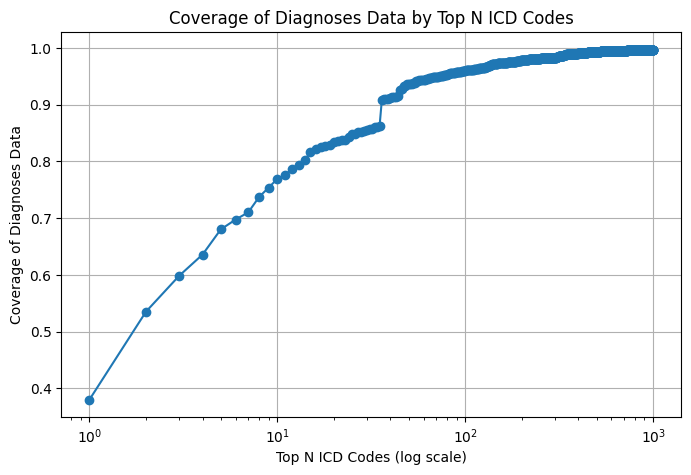

In [7]:
def plot_top_n_coverage(df, n=1000):
    df = df.dropna(subset=['ICD9_CODE'])
    df['ICD9_CODE'] = df['ICD9_CODE'].apply(lambda codes: [str(code) for code in codes] if isinstance(codes, (list, tuple)) else [str(codes)])
    all_codes = [code for codes in df['ICD9_CODE'] for code in codes]
    code_counts = Counter(all_codes)
    coverages = []
    pows = [10**i for i in range(int(np.log10(n))+1) if 10**i <= n]
    for k in range(1, n+1):
        current_top = [code for code, _ in code_counts.most_common(k)]
        cov = df['ICD9_CODE'].apply(lambda codes: any(code in current_top for code in codes)).mean()
        coverages.append(cov)
        if (k in pows):
            print(f'Coverage for top {k} codes: {cov*100:.2f}%')
    plt.figure(figsize=(8,5))
    plt.plot(range(1, n+1), coverages, marker='o')
    plt.xscale('log')
    plt.xlabel('Top N ICD Codes (log scale)')
    plt.ylabel('Coverage of Diagnoses Data')
    plt.title('Coverage of Diagnoses Data by Top N ICD Codes')
    plt.grid(True, which='major', axis='both')
    plt.show()

plot_top_n_coverage(merged)

In [8]:
all_codes = [code for codes in merged['ICD9_CODE'] for code in codes]
top100 = set([code for code, _ in Counter(all_codes).most_common(100)])

def filter_top100(row):
    filtered = [code for code in row if code in top100]
    return filtered if filtered else None

merged['ICD9_CODE'] = merged['ICD9_CODE'].apply(filter_top100)
merged = merged.dropna(subset=['ICD9_CODE'])

In [9]:
# Ensure ICD9_CODE is always a list
merged["ICD9_CODE"] = merged["ICD9_CODE"].apply(
    lambda x: x if isinstance(x, list) else [x]
)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(merged["ICD9_CODE"])


In [10]:
train, temp = train_test_split(merged, test_size=0.2, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=7)
print(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")

Train shape: (40500, 3), Validation shape: (5062, 3), Test shape: (5063, 3)


In [11]:
X_train, y_train = train["TEXT"], train["ICD9_CODE"]
X_val, y_val     = val["TEXT"], val["ICD9_CODE"]
X_test, y_test   = test["TEXT"], test["ICD9_CODE"]

In [12]:
vectorizer = TfidfVectorizer(
    max_features=5000,   # limit features for speed/memory
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words="english"
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

In [13]:
# 1. Vectorize text (fit on train only)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train['TEXT'])
X_val_tfidf   = vectorizer.transform(val['TEXT'])
X_test_tfidf  = vectorizer.transform(test['TEXT'])

# 2. Multi-label binarize ICD9 codes (fit on train only)
mlb = MultiLabelBinarizer()
y_train_enc = mlb.fit_transform(train['ICD9_CODE'])
y_val_enc   = mlb.transform(val['ICD9_CODE'])
y_test_enc  = mlb.transform(test['ICD9_CODE'])

# 3. Define models to try
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=200)),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(
        n_estimators=20, max_depth=10, n_jobs=-1, max_features='sqrt', min_samples_split=5, min_samples_leaf=2)),
    "Linear SVC": OneVsRestClassifier(LinearSVC())
}

results = {}         # For summary metrics
full_reports = {}    # For full classification reports

# 4. Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train_enc)
    y_val_pred = model.predict(X_val_tfidf)

    # Full classification report as dictionary
    report_dict = classification_report(
        y_val_enc, y_val_pred, target_names=mlb.classes_,
        output_dict=True, zero_division=0
    )

    # Store micro/macro scores for quick comparison
    results[name] = {
        "Micro F1": report_dict["micro avg"]["f1-score"],
        "Macro F1": report_dict["macro avg"]["f1-score"]
    }

    # Store full report for later analysis
    full_reports[name] = report_dict

# 5. Show comparison table
results_df = pd.DataFrame(results).T.sort_values("Micro F1", ascending=False)
print("\nModel Comparison:")
print(results_df)

Training Logistic Regression...
Training Random Forest...
Training Linear SVC...

Model Comparison:
                     Micro F1  Macro F1
Linear SVC           0.489973  0.342606
Logistic Regression  0.405325  0.233011
Random Forest        0.223874  0.080445


In [14]:
full_reports["Logistic Regression"]

{'00845': {'precision': 0.8787878787878788,
  'recall': 0.2230769230769231,
  'f1-score': 0.3558282208588957,
  'support': 130.0},
 '0389': {'precision': 0.5377358490566038,
  'recall': 0.16863905325443787,
  'f1-score': 0.25675675675675674,
  'support': 338.0},
 '07054': {'precision': 0.6153846153846154,
  'recall': 0.06896551724137931,
  'f1-score': 0.12403100775193798,
  'support': 116.0},
 '2449': {'precision': 0.8240740740740741,
  'recall': 0.3912087912087912,
  'f1-score': 0.5305514157973175,
  'support': 455.0},
 '25000': {'precision': 0.7155963302752294,
  'recall': 0.2805755395683453,
  'f1-score': 0.40310077519379844,
  'support': 834.0},
 '2639': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 125.0},
 '2720': {'precision': 0.7540983606557377,
  'recall': 0.16546762589928057,
  'f1-score': 0.2713864306784661,
  'support': 556.0},
 '2724': {'precision': 0.7611548556430446,
  'recall': 0.3431952662721893,
  'f1-score': 0.4730831973898858,
  'support': 845.0},
 '

In [15]:
pd.DataFrame(full_reports["Logistic Regression"]).T

,precision,recall,f1-score,support
00845,0.878788,0.223077,0.355828,130.0
0389,0.537736,0.168639,0.256757,338.0
07054,0.615385,0.068966,0.124031,116.0
2449,0.824074,0.391209,0.530551,455.0
25000,0.715596,0.280576,0.403101,834.0
...,...,...,...,...
V5867,0.547170,0.125541,0.204225,231.0
micro avg,0.764026,0.275827,0.405325,29475.0
macro avg,0.597634,0.172917,0.233011,29475.0
weighted avg,0.672719,0.275827,0.350393,29475.0


In [16]:
full_reports["Random Forest"]

{'00845': {'precision': 1.0,
  'recall': 0.007692307692307693,
  'f1-score': 0.015267175572519083,
  'support': 130.0},
 '0389': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 338.0},
 '07054': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 116.0},
 '2449': {'precision': 0.9545454545454546,
  'recall': 0.046153846153846156,
  'f1-score': 0.0880503144654088,
  'support': 455.0},
 '25000': {'precision': 0.7386363636363636,
  'recall': 0.07793764988009592,
  'f1-score': 0.14099783080260303,
  'support': 834.0},
 '2639': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 125.0},
 '2720': {'precision': 0.7142857142857143,
  'recall': 0.017985611510791366,
  'f1-score': 0.03508771929824561,
  'support': 556.0},
 '2724': {'precision': 0.7152777777777778,
  'recall': 0.12189349112426036,
  'f1-score': 0.2082912032355915,
  'support': 845.0},
 '2749': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 193.0},
 '2760': {'precision': 0.0, 'recal

In [17]:
pd.DataFrame(full_reports["Random Forest"]).T

,precision,recall,f1-score,support
00845,1.000000,0.007692,0.015267,130.0
0389,0.000000,0.000000,0.000000,338.0
07054,0.000000,0.000000,0.000000,116.0
2449,0.954545,0.046154,0.088050,455.0
25000,0.738636,0.077938,0.140998,834.0
...,...,...,...,...
V5867,1.000000,0.017316,0.034043,231.0
micro avg,0.814523,0.129771,0.223874,29475.0
macro avg,0.297081,0.064659,0.080445,29475.0
weighted avg,0.467858,0.129771,0.170669,29475.0


In [18]:
full_reports["Linear SVC"]

{'00845': {'precision': 0.8055555555555556,
  'recall': 0.4461538461538462,
  'f1-score': 0.5742574257425742,
  'support': 130.0},
 '0389': {'precision': 0.5652173913043478,
  'recall': 0.2692307692307692,
  'f1-score': 0.36472945891783565,
  'support': 338.0},
 '07054': {'precision': 0.6111111111111112,
  'recall': 0.1896551724137931,
  'f1-score': 0.2894736842105263,
  'support': 116.0},
 '2449': {'precision': 0.7849462365591398,
  'recall': 0.6417582417582418,
  'f1-score': 0.7061668681983071,
  'support': 455.0},
 '25000': {'precision': 0.7287822878228782,
  'recall': 0.473621103117506,
  'f1-score': 0.5741279069767442,
  'support': 834.0},
 '2639': {'precision': 0.75,
  'recall': 0.024,
  'f1-score': 0.046511627906976744,
  'support': 125.0},
 '2720': {'precision': 0.7048458149779736,
  'recall': 0.28776978417266186,
  'f1-score': 0.4086845466155811,
  'support': 556.0},
 '2724': {'precision': 0.746031746031746,
  'recall': 0.5005917159763313,
  'f1-score': 0.5991501416430595,
  '

In [19]:
pd.DataFrame(full_reports["Linear SVC"]).T

,precision,recall,f1-score,support
00845,0.805556,0.446154,0.574257,130.0
0389,0.565217,0.269231,0.364729,338.0
07054,0.611111,0.189655,0.289474,116.0
2449,0.784946,0.641758,0.706167,455.0
25000,0.728782,0.473621,0.574128,834.0
...,...,...,...,...
V5867,0.522727,0.199134,0.288401,231.0
micro avg,0.732725,0.368041,0.489973,29475.0
macro avg,0.627224,0.267705,0.342606,29475.0
weighted avg,0.669424,0.368041,0.445551,29475.0
